## Assignment 1: Model creation
**Course:** Security and Interpretability of Machine Learning algorithms <br>
**Student:** Danis Alukaev <br>
**Email:** d.alukaev@innopolis.university <br>
**Group:** B19-DS-01 

### 0. Prerequisites.

In [1]:
import torch 
import torchvision
import os
import pickle
import matplotlib
import albumentations as A
import random
import numpy as np

In [2]:
from albumentations import pytorch
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import balanced_accuracy_score

In [3]:
configs = {
    "num_workers": 4,
    "device": "cuda:0",
    "batch_size": 128,
    "epochs": 50
}

In [4]:
import warnings
warnings.filterwarnings("ignore")

### 1. Loading Data.

The CIFAR-10 dataset was downloaded from [official publisher](https://www.cs.toronto.edu/~kriz/cifar.html) and mounted to `data/cifar/` directory. Further, the loading of data will be performed through Dataset abstraction. Native implementation does not support transforms via Albumentations package, so I create a custom class for this purpose.

In [5]:
class AlbumentationsCIFAR10(CIFAR10):
    """
    Custom CIFAR10 dataset applying transformations according to
    Albumentations standard. Inherited from native PyTorch dataset
    implementing the retrival logic.
    """
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)
    
    def __getitem__(self, idx):
        image, label = self.data[idx], self.targets[idx]
        if self.transform is None:
            return image, label
        try:
            transformed = self.transform(image=image)['image']
        except Exception as e:
            print(e)
            transformed = self.transform(image)
        return transformed, label
            

There will be two types of transforms: train and test. Both include the normalization and converting to Tensors. Still, the former one also applies random augmentations to increase the robustness of the model. For instance, there are horizontal flip, scale rotations, elastic transforms. By construction, augmentations will be applied on each epoch, so that the model will be trained on previously unseen samples.

In [6]:
train_augmentations = A.Compose([
    A.augmentations.transforms.Normalize(),
    A.HorizontalFlip(p=0.5),
    A.augmentations.geometric.transforms.ShiftScaleRotate(p=0.5),
    A.augmentations.geometric.transforms.ElasticTransform(p=0.1),
    pytorch.transforms.ToTensorV2(),
])

test_augmentations = A.Compose([
    A.augmentations.transforms.Normalize(),
    pytorch.transforms.ToTensorV2(),
])

Further in the notebook, there will be used validation, train, and test datasets. The validation set will be used to check the overall performance of the trained model. The train and test sets will be used for training the model.

In [7]:
trainset = AlbumentationsCIFAR10(root='data', train=True, download=True, transform=train_augmentations)
trainloader = DataLoader(trainset, batch_size=configs['batch_size'], shuffle=True, num_workers=configs['num_workers'])

Files already downloaded and verified


In [8]:
split_ration = 0.5

controlset = AlbumentationsCIFAR10(root='data', train=False, download=True, transform=test_augmentations)
test_size = int(split_ration * len(controlset))
validation_size = len(controlset) - test_size
testset, validationset = torch.utils.data.random_split(controlset, [test_size, validation_size], generator=torch.Generator().manual_seed(42))
testloader = DataLoader(testset, batch_size=configs['batch_size'], shuffle=False, num_workers=configs['num_workers'])
validationloader = DataLoader(validationset, batch_size=configs['batch_size'], shuffle=False, num_workers=configs['num_workers'])

Files already downloaded and verified


In [9]:
print(f"Datasets' sizes: train {len(trainset)}, test: {len(testset)}, validation: {len(validationset)}")

Datasets' sizes: train 50000, test: 5000, validation: 5000


Let's examine five random samples from training population. The images themselves are a litle bit messy, but still the depicted entity can be distinguished. Note that these are the images after transformations (different from the original).

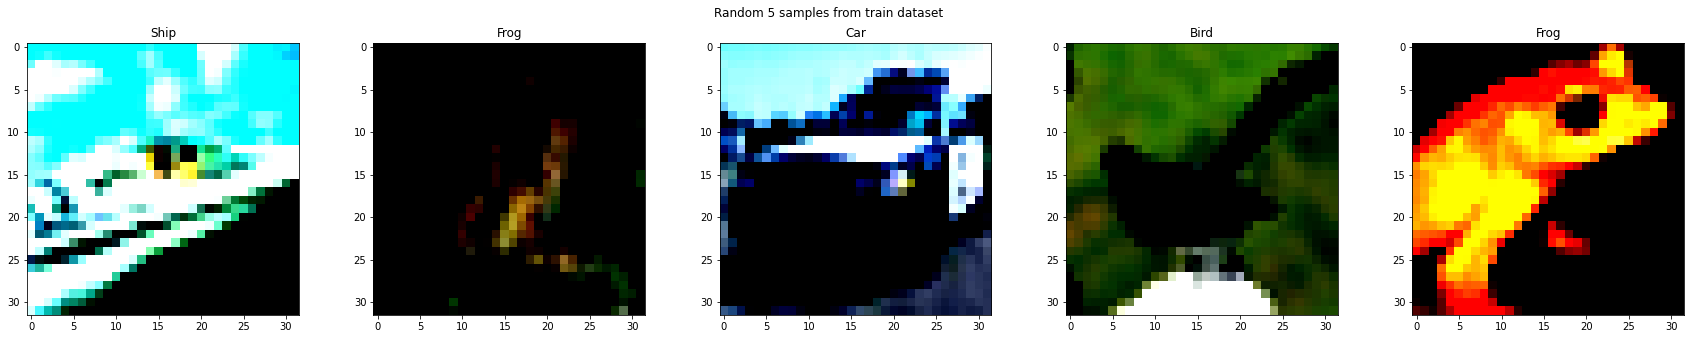

In [11]:
labels_text = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
classes = {i: labels_text[i] for i in range(len(labels_text))}

fig, axes = plt.subplots(1, 5)
fig.set_size_inches(30, 5)
fig.suptitle("Random 5 samples from train dataset")
for ax in axes:
    idx = random.randint(0, len(trainset)-1)
    image, label = trainset[idx]
    ax.set_title(f"{classes[label]}")
    image = np.clip(image.permute(1, 2, 0), 0, 1)
    ax.imshow(image)
plt.show()

### 2. Building a Model.

Multi-label classification of objects in images is known problem. Various state-of-art model were developed. For instance, the Residual Network (ResNet) significantly improved the performance of deep neural networks. The overall idea and architecture are presented in ["Deep Residual Learning for Image Recognition"](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming H. et al. For this assignment I will implement the variation of ResNet with 34 layers.

In [12]:
class ResidualBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.stride = stride
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = self.__make_shortcut()
        
    def __make_shortcut(self):
        if self.stride == 1 and self.expansion * self.out_channels == self.in_channels:
            return nn.Sequential()
        shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expansion * self.out_channels, kernel_size=1, stride=self.stride, bias=False),
            nn.BatchNorm2d(self.expansion * self.out_channels) 
        )
        return shortcut
    
    def forward(self, x):
        _x = x.clone() 
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += self.shortcut(_x)
        x = F.relu(x)
        return x

In [13]:
class ResNet(nn.Module):
    def __init__(self, in_channels, out_channels, blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.blocks = blocks
        self.num_classes = num_classes
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.layers = []
        channels = out_channels
        for idx, num_blocks in enumerate(blocks):
            stride = 1 if idx == 0 else 2
            layer = self.__make_layer(ResidualBlock, channels, num_blocks, stride)
            self.layers.append(layer)
            channels *= 2  
        self.layers = nn.ModuleList(self.layers)
        
        self.fc1 = nn.Linear(channels // 2 * ResidualBlock.expansion, num_classes) 

    def __make_layer(self, Block, channels, num_blocks, first_stride):
        blocks = []
        for idx in range(num_blocks):
            stride = first_stride if idx == 0 else 1
            block = Block(self.out_channels, channels, stride)
            self.out_channels = channels * Block.expansion
            blocks.append(block)
        layer = nn.Sequential(*blocks)
        return layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        for layer in self.layers:
            x = layer(x)
        x = F.avg_pool2d(x, 4)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Further in the pipeline train and test routines will be frequently used. Thus, it is better to define them beforehand. Note that both methods return per batch loss and weighted accuracy. The  (since the dataset is imbalanced). 

In [14]:
def train(model, criterion, loader, optimizer):
    """
    Training routine for the model. Iterates over the elements in the loader.
    Uses criterion to calculate the loss. Applies optimizer to update weights.
    :param model: PyTorch model
    :param criterion: method computing the loss 
    :param loader: dataloader
    :param optimizer: optimization algorithm
    :return: per batch loss, average balanced accuracy
    """
    model.to(configs['device'])
    model.train()
    
    train_loss = 0.0
    accuracy = []
    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(configs['device']), labels.to(configs['device'])
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        _, predicted_classes = predictions.max(1)
        predicted_classes = predicted_classes.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        accuracy.append(balanced_accuracy_score(labels, predicted_classes))
        
    return train_loss / len(loader), np.mean(np.array(accuracy))    

In [15]:
def test(model, criterion, loader):
    """
    Testing routine for the model. Iterates over the elements in the loader.
    Uses criterion to calculate the loss. 
    :param model: PyTorch model
    :param criterion: method computing the loss 
    :param loader: dataloader
    :return: per batch loss, average balanced accuracy
    """
    model.eval()
    test_loss = 0.0
    accuracy = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(configs['device']), labels.to(configs['device'])
            predictions = model(images)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            _, predicted_classes = predictions.max(1)
            predicted_classes = predicted_classes.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            accuracy.append(balanced_accuracy_score(labels, predicted_classes))
    
    return test_loss / len(loader), np.mean(np.array(accuracy))

### 3. Training the model.

The training of the model will be performed with following configuration:
- Cross Entropy Loss function
- AdamW optimization algorithm
- Cosine Annealing LR scheduler

In [16]:
model = ResNet(3, 64, [3, 4, 6, 3]).to(configs['device'])
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=configs['epochs'])

In [17]:
losses = {'train': [], 'test': []}
accuracies = {'train': [], 'test': []}

for epoch in range(configs['epochs']):  
    train_loss, train_accuracy = train(model, criterion, trainloader, optimizer)
    test_loss, test_accuracy = test(model, criterion, testloader)
    scheduler.step()
    
    losses['train'].append(train_loss)
    losses['test'].append(test_loss)
    accuracies['train'].append(train_accuracy)
    accuracies['test'].append(test_accuracy)
    print(f"Epoch: {epoch+1:02d} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Train accuracy: {train_accuracy:.5f} | Test accuracy: {test_accuracy:.5f}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss, 
    }, os.path.join("weights", f"{epoch}.pt"))

Epoch: 01 | Train loss: 1.58276 | Test loss: 1.19336 | Train accuracy: 0.43156 | Test accuracy: 0.58173
Epoch: 02 | Train loss: 1.23471 | Test loss: 0.94364 | Train accuracy: 0.56465 | Test accuracy: 0.67289
Epoch: 03 | Train loss: 1.04406 | Test loss: 0.84860 | Train accuracy: 0.63621 | Test accuracy: 0.71472
Epoch: 04 | Train loss: 0.92214 | Test loss: 0.77768 | Train accuracy: 0.67943 | Test accuracy: 0.73171
Epoch: 05 | Train loss: 0.84715 | Test loss: 0.72121 | Train accuracy: 0.70659 | Test accuracy: 0.75689
Epoch: 06 | Train loss: 0.78574 | Test loss: 0.61786 | Train accuracy: 0.72985 | Test accuracy: 0.78336
Epoch: 07 | Train loss: 0.73820 | Test loss: 0.54637 | Train accuracy: 0.74534 | Test accuracy: 0.81917
Epoch: 08 | Train loss: 0.69694 | Test loss: 0.50448 | Train accuracy: 0.75984 | Test accuracy: 0.82555
Epoch: 09 | Train loss: 0.65219 | Test loss: 0.53358 | Train accuracy: 0.77275 | Test accuracy: 0.81537
Epoch: 10 | Train loss: 0.62761 | Test loss: 0.57719 | Train acc

To determine which configuration of weights performed the best, let's plot the behaviour of losses and accuracies (further, metrics) over the time. Hopefully, the model does not seem to either underfit or overfit. Apparently, the behaviour of test metrics is quite similar to train.

In [38]:
def visualize(losses, accuracies):
    """
    Method used to visualize the behaviour of losses and accuracies over the time.
    :param losses: dict with keys 'train', 'test' and values - losses.
    :param accuracies: dict with keys 'train', 'test' and values - balanced accuracies.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(25, 8)
    fig.suptitle(f"Training process")
    ax1.set_title(f"Comparison of losses")
    ax1.grid(linestyle='--')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(np.arange(len(losses['train'])), np.array(losses['train']), '-o', label='Train', c='b')
    ax1.plot(np.arange(len(losses['test'])), np.array(losses['test']), '-o', label='Test', c='r')
    ax1.legend()

    ax2.set_title(f"Comparison of accuracies")
    ax2.grid(linestyle='--')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(np.arange(len(accuracies['train'])), np.array(accuracies['train']), '-o', label='Train', c='b')
    ax2.plot(np.arange(len(accuracies['test'])), np.array(accuracies['test']), '-o', label='Test', c='r')
    ax2.legend()

    plt.show() 

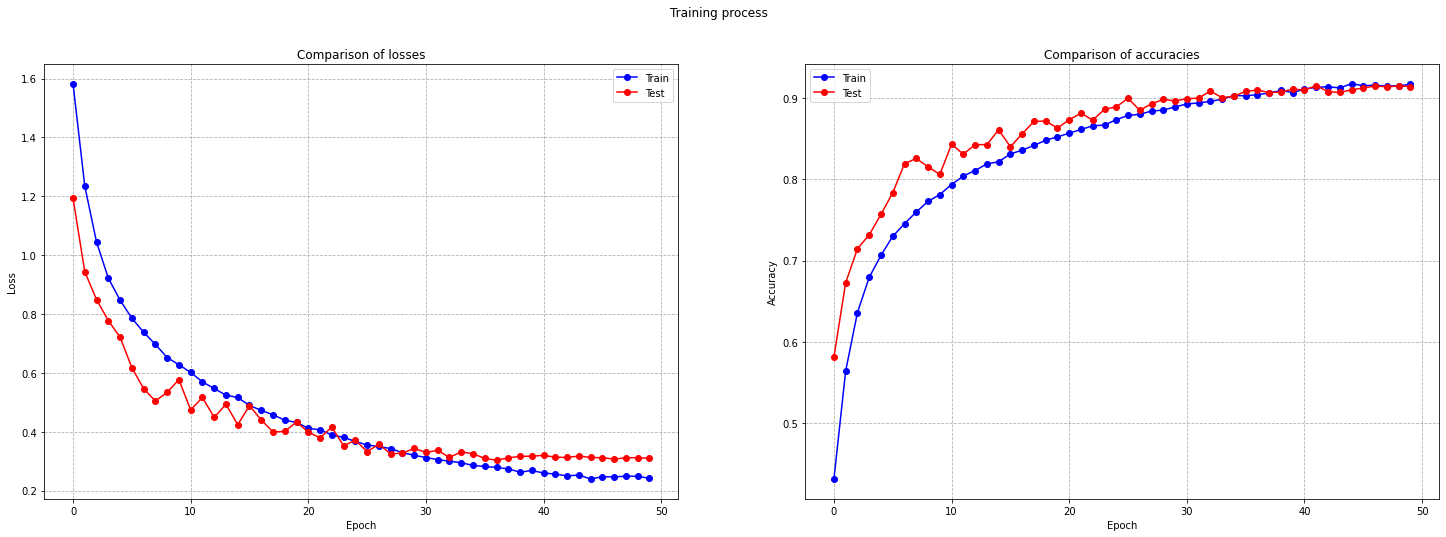

In [39]:
visualize(losses, accuracies)

The best performance is shown on the epoch 49, so these weights will be used for inference.

### 4. Model Evaluation.

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

def validate(model, criterion, loader):
    model.eval()
    test_loss = 0.0
    history = {"True": [], "Predicted": []}
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images, labels = images.to(configs['device']), labels.to(configs['device'])
            predictions = model(images)
            loss = criterion(predictions, labels)
            test_loss += loss.item()
            
            _, predicted_classes = predictions.max(1)
            predicted_classes = predicted_classes.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            
            history["True"] += list(labels)
            history["Predicted"] += list(predicted_classes)
    
    accuracy = balanced_accuracy_score(history["True"], history["Predicted"])
    ConfusionMatrixDisplay.from_predictions(history["True"], history["Predicted"], display_labels=labels_text, xticks_rotation='vertical')
    plt.show()
    return accuracy

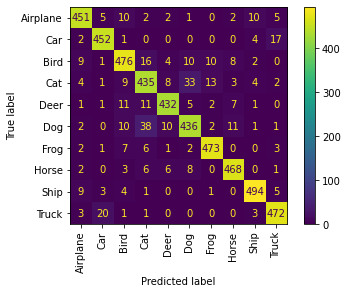

In [20]:
checkpoint = torch.load(os.path.join("weights", "49.pt"))
inferenced = ResNet(3, 64, [3, 4, 6, 3]).to(configs['device'])
inferenced.load_state_dict(checkpoint['model_state_dict'])
inferenced.eval()

accuracy = validate(inferenced, criterion, validationloader)

In [21]:
print(f"The model has reached {accuracy * 100:.2f}% of weighted accuracy.")

The model has reached 91.84% of weighted accuracy.


### 6. Extras.

For educational purposes, there was applied an adversarial attack to the final model. The code for targeted attack in the following cells is adapted from ["Introduction on Adversarial Robustness"](https://adversarial-ml-tutorial.org/introduction/). I give all credits to the authors and don't pretend that the following code is mine.

Consider an attack on the image with horse. As a target there will be taken frog, because the model performs well in distinguishin these two entities (see confustion matrix above). 

In [22]:
image, label = validationset[14]

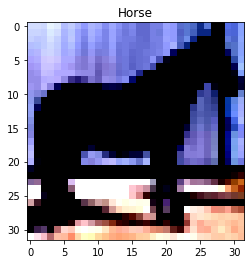

In [24]:
plt.title(labels_text[label])
plt.imshow(np.clip(image.permute(1, 2, 0), 0, 1))
plt.show()

In [40]:
_image = torch.unsqueeze(image, 0)
prediction = inferenced(_image.to(configs['device']))
_, predicted_class = prediction.max(1)
print(labels_text[predicted_class])

Horse


In [41]:
"""
Taken from https://adversarial-ml-tutorial.org/introduction/.
All rights reserved.
"""

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [51]:
"""
Adapted from https://adversarial-ml-tutorial.org/introduction/.
All rights reserved.
"""

epsilon = 0.1
delta = torch.zeros_like(_image, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for idx in range(200):
    pred = inferenced(norm(_image + delta).to(configs['device']))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([7]).to(configs['device'])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([6]).to(configs['device'])))
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

_, predicted_class = pred.max(1)
print("Predicted class: ", labels_text[predicted_class])

Predicted class:  Frog


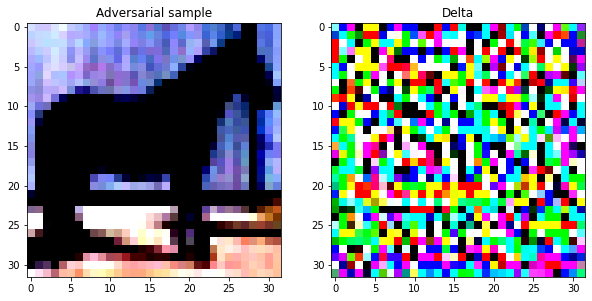

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
ax1.set_title(f"Adversarial sample")
ax1.imshow(np.clip((_image + delta).detach().numpy().squeeze().transpose(1,2,0), 0, 1))

ax2.set_title(f"Delta")
ax2.imshow(np.clip((50*delta+0.5)[0].detach().numpy().transpose(1,2,0), 0, 1))

plt.show() 